In [1]:
# Importing the necessary libraries
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import writer, summary
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
import os

In [2]:
#Setting up the Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = datasets.MNIST(root="data",
                            train=True,
                            download=True,
                            transform=ToTensor())
test_data = datasets.MNIST(root="data",
                           train=False,
                           download = True,
                           transform = ToTensor())

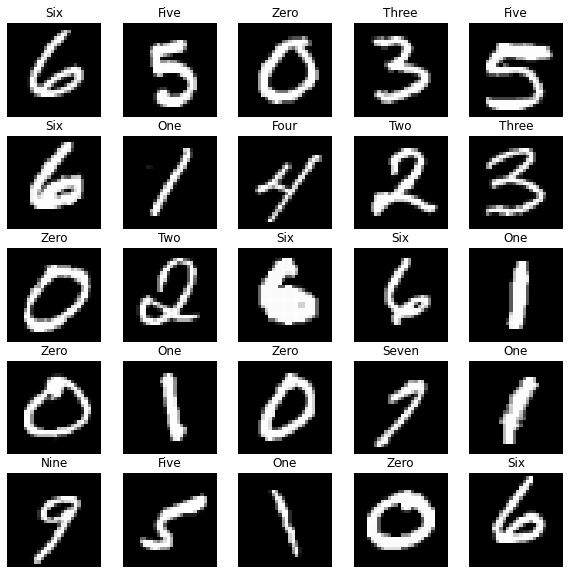

6


In [4]:
# Visualizing the data
import matplotlib.pyplot as plt
labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eigth",
    9: "Nine"
}
figure = plt.figure(figsize = [10,10])
columns, rows = 5,5
for i in range(1, columns * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, columns, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()
print(label)

In [5]:
class MyDataset(Dataset):
    def __init__(self, vector):
        self.labels = []
        self.data = []
        for i,(_tensor_,label) in enumerate(vector):
            self.labels.append(np.eye(10)[label])
            self.data.append(_tensor_)
        self.labels = np.array(self.labels)
        self.labels = torch.Tensor(self.labels)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
my_train = MyDataset(train_data)
my_test = MyDataset(test_data)

In [7]:
print(len(my_train))

60000


In [8]:
#DataLoader
batch_size = 64
train_dl = DataLoader(my_train, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(my_test, batch_size = batch_size, shuffle = True)

In [23]:
print(my_train[0][1])

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [9]:
print(next(iter(train_dl))[0].shape)

torch.Size([64, 1, 28, 28])


In [11]:
# Defining the Network
class CONVNET(nn.Module):
    def __init__(self):
        super(CONVNET, self).__init__()
        self.S = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 10,kernel_size = 3,padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
        nn.Conv2d(in_channels = 10, out_channels = 16,kernel_size = 3,padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
        )
        self.fc1 = nn.Linear(16*7*7, 10)

    def forward(self, x):
        out = self.S(x)
        #print(out.shape)
        out = out.reshape(out.shape[0], -1)
        #print(out.shape)
        out = self.fc1(out)
        #print(out)
        out = F.softmax(out, dim = 1)
        #print(out)
        return out

NN = CONVNET().to(device)
print(NN)
test = torch.randn(64,1,28,28).to(device)

CONVNET(
  (S): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [22]:
with torch.no_grad():
    print(NN(my_train[9000][0].unsqueeze(dim = 0).to(device)))
    res = NN(my_train[9000][0].unsqueeze(dim = 0).to(device))
    #print(res.max(1)[1].item())

tensor([[5.9047e-04, 3.2900e-10, 1.2699e-08, 1.3587e-10, 4.4724e-09, 2.1819e-07,
         9.9937e-01, 6.7165e-11, 3.7874e-05, 1.1374e-08]], device='cuda:0')


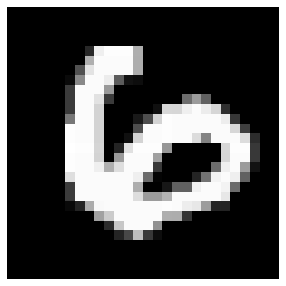

In [23]:
plt.figure(figsize = [5,5])
plt.imshow(my_train[9000][0].squeeze().to("cpu"), cmap = "gray")
plt.axis("off")
plt.show()

In [21]:
EPOCHS = 5
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(NN.parameters(), lr = learning_rate)
for EPOCH in range(EPOCHS):
    for inputs, labels in train_dl:
        predictions = NN(inputs.to(device))
        loss = criterion(predictions, labels.to(device))

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # updates
        optimizer.step()
    print(f"Epoch:{EPOCH},Loss:{loss:.6f}")

Epoch:0,Loss:0.005604
Epoch:1,Loss:0.007439
Epoch:2,Loss:0.000246
Epoch:3,Loss:0.000078
Epoch:4,Loss:0.001953


In [25]:
# Validazione
import re
def validation_acc(dataset):
    if dataset == train_dl:
        data_type = "Training"
    else:
        data_type = "Testing"
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x,y in dataset:
            x = x.to(device)
            y = y.to(device)
            scores = NN(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y.max(1)[1]).sum()
            num_samples += predictions.size(0)
        print(f"Hai preso {num_correct} / {num_samples}, dunque accuracy del {data_type}:{float(num_correct)/float(num_samples)*100:.3f}%")
validation_acc(val_dl)

Hai preso 9828 / 10000, dunque accuracy del Testing:98.280%


torch.return_types.max(
values=tensor([0.9843], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4], device='cuda:0'))
tensor([4], device='cuda:0')


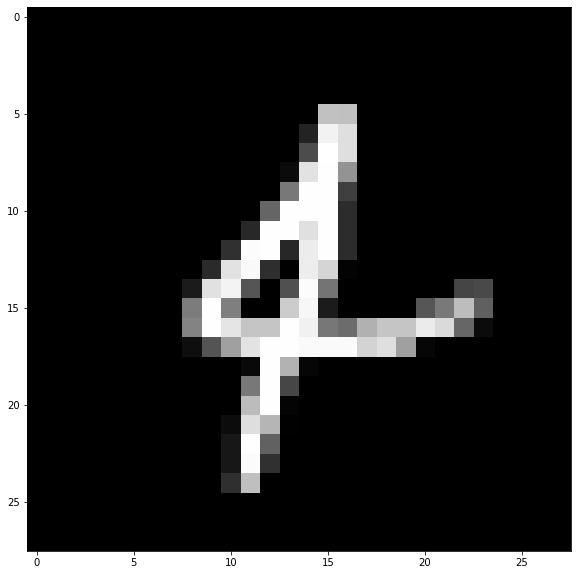

In [26]:
#testing how to pass data test data into the network
test_vec = my_test[300][0].unsqueeze(dim=0).to(device)
res = NN(test_vec)
print(res.max(1))
_,prediction = res.max(1)
print(prediction)
plt.figure(figsize = [10,10])
plt.imshow(test_vec.squeeze().to("cpu"), cmap = "gray")
plt.show()

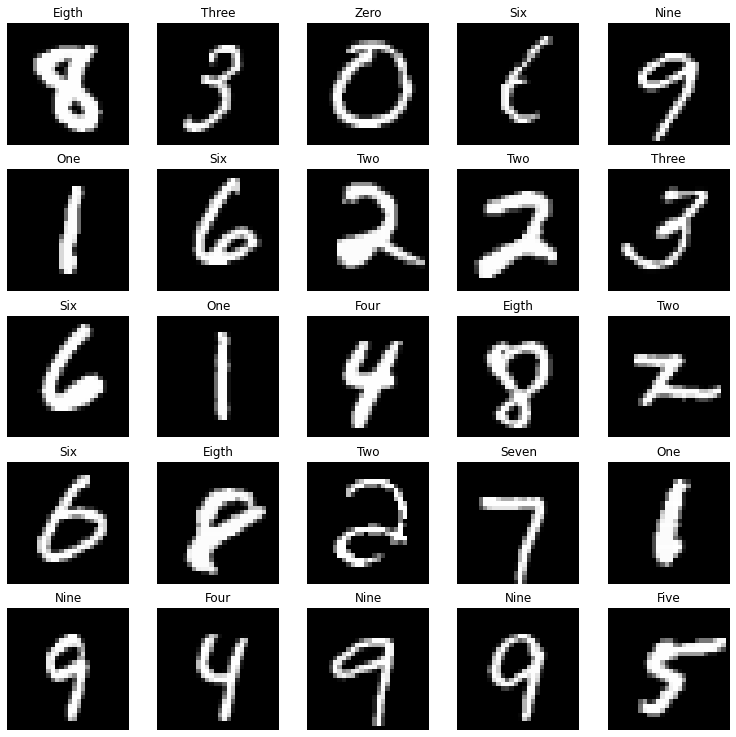

In [27]:
figure = plt.figure(figsize = [13,13])
rows, columns = 5,5
with torch.no_grad():
    for i in range(1,rows*columns + 1):
        idx = torch.randint(len(my_test), (1,)).item()
        test_tensor = my_test[idx][0].unsqueeze(dim = 0).to(device)
        res = NN(test_tensor)
        _,prediction = res.max(1)
        figure.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels_map[prediction.item()])
        plt.imshow(test_tensor.squeeze().to("cpu"), cmap = "gray")

    plt.show()